# Training process 1
+ Model name：`Training_1_Res_NLLLoss_2FC_200e.pt` ; 
+ Path： '`./model/Training_1_Res_NLLLoss_2FC_200e.pt`'
+ Training network：`resnet50 with Two fully connected layers`
+ Loss function：`NLLLoss`
+ Optimizer： `Adam`
+ epoch： `200`
+ sample pairing: `False ` 

### Data Preparation

In [1]:
import torch
import torchvision
from torchvision import datasets,transforms 
from face_crop import face_crop


train_dir = './data/face_data/train/'
valid_dir = './data/face_data/val/'

mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    face_crop(),
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,
                         std=std),
    transforms.RandomErasing(),
])


valid_transform = transforms.Compose([
    face_crop(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,
                         std=std),
])

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128,
                                           shuffle=True, num_workers=4)


valid_data = datasets.ImageFolder(root=valid_dir,
                                transform=valid_transform)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=64,
                                          shuffle=True, num_workers=4)


In [2]:
train_data

Dataset ImageFolder
    Number of datapoints: 10481
    Root location: ./data/face_data/train/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=(-10, 10), resample=False, expand=False)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [3]:
valid_data

Dataset ImageFolder
    Number of datapoints: 6821
    Root location: ./data/face_data/val/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [4]:
class_names = train_data.classes

/home/wang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  app.launch_new_instance()


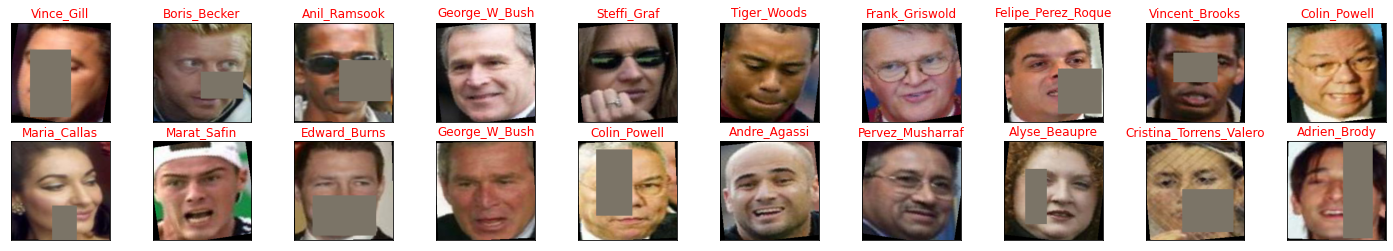

In [5]:
#Transform Data visualize
import numpy as np
import matplotlib.pyplot as plt
images, classes = next(iter(train_loader))

def imshow(inp):
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    

fig = plt.figure(figsize=(25, 4))
    # display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(class_names[classes[idx]], color='red') 

### Training Network

In [6]:
# Resnet50 with Two fully connected layers
from torchvision import models
from torch import nn
from collections import OrderedDict

model_resnet50 = models.resnet50(pretrained=True)
for param in model_resnet50.parameters():
    param.requires_grad = False

classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(2048, 1024)),  
    ('relu', nn.ReLU()),
    ('dropout', nn.Dropout(p=0.2)),
    ('fc2', nn.Linear(1024, len(class_names))),
    ('output', nn.LogSoftmax(dim=1))
]))

# Replace the classifier part of the introduced net!
model_resnet50.fc = classifier

In [6]:
#model_resnet50

## Trainning process

In [7]:
import torch 
import torch.nn.functional as F
from torch import nn, optim  
from tqdm import tqdm
import numpy as np
from focal_loss import FocalLoss

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train(model='resnet50', data_augumentation=False, loss='NLLLoss', lr=0.003, weight_decay=1e-5, epoch=None):
    if model == 'model_resnet50':
        model = model_resnet50
    
    model.to(device)
    
    if data_augumentation:
        pass
        
    if loss == 'NLLLoss':
        print('use NLLLoss')
        criterion = nn.NLLLoss()
        
    if loss == 'FocalLoss':
        print('use focal loss')
        criterion = FocalLoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)    
    
    
    epochs = epoch
    train_losses, valid_losses = [], []
    valid_loss_min = np.inf

    for e in range(epochs):
        train_loss = 0
        valid_loss = 0
        accuracy = 0.0

        model.train()
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            log_ps = model(images)
            loss = criterion(log_ps, labels)
            loss = loss.requires_grad_()
            loss.backward()

            optimizer.step()
            train_loss += loss.item() * images.size(0)

        model.eval()  # Close dropout
        with torch.no_grad():
            for images, labels in tqdm(valid_loader):
                images, labels = images.to(device), labels.to(device)
                
                # Verify loss
                log_ps = model(images)
                loss = criterion(log_ps, labels)
                valid_loss += loss.item() * images.size(0)
                
                # Verify accuracy
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))

        # An epoch loss 
        train_loss = train_loss/len(train_loader.sampler)   
        valid_loss = valid_loss/len(valid_loader.sampler)
        valid_accuracy = accuracy / len(valid_loader)

        # Add the loss to the list for graphing
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        
        # Add the code to save this list to the local to use this loss transformation list when not training in the future, 
        # such as comparing different models
        train_loss_array = np.array(train_losses)
        valid_loss_array = np.array(valid_losses)
        valid_accuracy_array = np.array(valid_accuracy)
        
        
        np.save('./results/Training_1/Ftp1_train_loss_array.npy', train_loss_array)
        np.save('./results/Training_1/Ftp1_valid_loss_array.npy', valid_loss_array)
        np.save('./results/Training_1/Ftp1_valid_accuracy_array.npy', valid_accuracy_array)
        
   
        # Print an epoch information
        print('Epoch {}/{}..'.format(e + 1, epochs),
              'Train loss:{:.4f}..'.format(train_loss),
              'Valid loss:{:.4f}..'.format(valid_loss),
              'Valid accuracy:{:.4f}%..'.format(valid_accuracy * 100))
        
        # Save the optimal model
        if valid_loss <= valid_loss_min:
            print('valid_loss decreased: ({:.4f} --> {:.4f}), saving model "Training_1_Res_NLLLoss_2FC_200e.pt"..'.format(valid_loss_min, valid_loss))
            torch.save(model, './model/Training_1_Res_NLLLoss_2FC_200e.pt.pt')
            valid_loss_min = valid_loss

In [9]:
train(model='model_resnet50', data_augumentation=False, loss='NLLLoss', lr=0.001, weight_decay=1e-5, epoch=200)

100%|██████████| 107/107 [02:12<00:00,  1.24s/it]
/home/wang/anaconda3/envs/nn_last/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/wang/anaconda3/envs/nn_last/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/wang/anaconda3/envs/nn_last/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/wang/anaconda3/envs/nn_last/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of 

Epoch 1/200.. Train loss:8.3117.. Valid loss:8.4458.. Valid accuracy:1.5732%..
valid_loss decreased: (inf --> 8.4458), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 2/200.. Train loss:7.9246.. Valid loss:8.4794.. Valid accuracy:1.5732%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 3/200.. Train loss:7.8450.. Valid loss:8.5996.. Valid accuracy:1.6647%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 4/200.. Train loss:7.7990.. Valid loss:8.4542.. Valid accuracy:2.0736%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 5/200.. Train loss:7.7302.. Valid loss:8.3592.. Valid accuracy:2.1095%..
valid_loss decreased: (8.4458 --> 8.3592), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 6/200.. Train loss:7.6313.. Valid loss:8.3326.. Valid accuracy:2.1825%..
valid_loss decreased: (8.3592 --> 8.3326), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 7/200.. Train loss:7.5449.. Valid loss:8.3013.. Valid accuracy:2.0444%..
valid_loss decreased: (8.3326 --> 8.3013), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 8/200.. Train loss:7.4384.. Valid loss:8.1606.. Valid accuracy:2.4201%..
valid_loss decreased: (8.3013 --> 8.1606), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 9/200.. Train loss:7.3492.. Valid loss:7.9931.. Valid accuracy:2.6577%..
valid_loss decreased: (8.1606 --> 7.9931), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 10/200.. Train loss:7.2455.. Valid loss:7.9521.. Valid accuracy:2.7414%..
valid_loss decreased: (7.9931 --> 7.9521), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 11/200.. Train loss:7.1341.. Valid loss:7.8338.. Valid accuracy:2.8290%..
valid_loss decreased: (7.9521 --> 7.8338), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 12/200.. Train loss:7.0319.. Valid loss:7.6887.. Valid accuracy:2.8329%..
valid_loss decreased: (7.8338 --> 7.6887), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 13/200.. Train loss:6.9068.. Valid loss:7.5741.. Valid accuracy:3.1688%..
valid_loss decreased: (7.6887 --> 7.5741), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 14/200.. Train loss:6.7764.. Valid loss:7.4246.. Valid accuracy:3.0334%..
valid_loss decreased: (7.5741 --> 7.4246), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 15/200.. Train loss:6.6497.. Valid loss:7.2827.. Valid accuracy:3.0958%..
valid_loss decreased: (7.4246 --> 7.2827), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 16/200.. Train loss:6.5127.. Valid loss:7.1103.. Valid accuracy:3.3440%..
valid_loss decreased: (7.2827 --> 7.1103), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 17/200.. Train loss:6.3960.. Valid loss:6.9096.. Valid accuracy:3.3440%..
valid_loss decreased: (7.1103 --> 6.9096), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 18/200.. Train loss:6.2616.. Valid loss:6.7734.. Valid accuracy:3.5804%..
valid_loss decreased: (6.9096 --> 6.7734), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 19/200.. Train loss:6.1391.. Valid loss:6.5636.. Valid accuracy:3.4530%..
valid_loss decreased: (6.7734 --> 6.5636), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 20/200.. Train loss:6.0441.. Valid loss:6.4372.. Valid accuracy:3.6136%..
valid_loss decreased: (6.5636 --> 6.4372), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 21/200.. Train loss:5.9180.. Valid loss:6.2645.. Valid accuracy:4.1286%..
valid_loss decreased: (6.4372 --> 6.2645), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 22/200.. Train loss:5.8210.. Valid loss:6.1343.. Valid accuracy:4.2640%..
valid_loss decreased: (6.2645 --> 6.1343), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 23/200.. Train loss:5.7210.. Valid loss:6.0658.. Valid accuracy:4.8043%..
valid_loss decreased: (6.1343 --> 6.0658), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 24/200.. Train loss:5.6355.. Valid loss:5.9182.. Valid accuracy:5.4125%..
valid_loss decreased: (6.0658 --> 5.9182), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 25/200.. Train loss:5.5299.. Valid loss:5.7959.. Valid accuracy:5.9501%..
valid_loss decreased: (5.9182 --> 5.7959), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 26/200.. Train loss:5.4500.. Valid loss:5.7342.. Valid accuracy:7.1183%..
valid_loss decreased: (5.7959 --> 5.7342), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 27/200.. Train loss:5.3917.. Valid loss:5.6732.. Valid accuracy:7.8192%..
valid_loss decreased: (5.7342 --> 5.6732), saving model "Formal training process1 model_resnet50"..


100%|██████████| 107/107 [01:52<00:00,  1.05s/it]


Epoch 28/200.. Train loss:5.2964.. Valid loss:5.5469.. Valid accuracy:9.4401%..
valid_loss decreased: (5.6732 --> 5.5469), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 29/200.. Train loss:5.2251.. Valid loss:5.4561.. Valid accuracy:10.6510%..
valid_loss decreased: (5.5469 --> 5.4561), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 30/200.. Train loss:5.2138.. Valid loss:5.4440.. Valid accuracy:11.0677%..
valid_loss decreased: (5.4561 --> 5.4440), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 31/200.. Train loss:5.1358.. Valid loss:5.3061.. Valid accuracy:14.0163%..
valid_loss decreased: (5.4440 --> 5.3061), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 32/200.. Train loss:5.1075.. Valid loss:5.2780.. Valid accuracy:14.0629%..
valid_loss decreased: (5.3061 --> 5.2780), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 33/200.. Train loss:5.0263.. Valid loss:5.1728.. Valid accuracy:16.0181%..
valid_loss decreased: (5.2780 --> 5.1728), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 34/200.. Train loss:4.9844.. Valid loss:5.1559.. Valid accuracy:16.8386%..
valid_loss decreased: (5.1728 --> 5.1559), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 35/200.. Train loss:4.9359.. Valid loss:5.0979.. Valid accuracy:18.1888%..
valid_loss decreased: (5.1559 --> 5.0979), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 36/200.. Train loss:4.8658.. Valid loss:5.1100.. Valid accuracy:18.1343%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 37/200.. Train loss:4.8622.. Valid loss:4.9996.. Valid accuracy:20.2304%..
valid_loss decreased: (5.0979 --> 4.9996), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 38/200.. Train loss:4.8403.. Valid loss:4.9635.. Valid accuracy:20.8477%..
valid_loss decreased: (4.9996 --> 4.9635), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 39/200.. Train loss:4.7918.. Valid loss:4.9581.. Valid accuracy:21.1105%..
valid_loss decreased: (4.9635 --> 4.9581), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 40/200.. Train loss:4.7274.. Valid loss:4.9203.. Valid accuracy:22.1686%..
valid_loss decreased: (4.9581 --> 4.9203), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 41/200.. Train loss:4.7011.. Valid loss:4.8620.. Valid accuracy:24.2568%..
valid_loss decreased: (4.9203 --> 4.8620), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 42/200.. Train loss:4.6646.. Valid loss:4.8026.. Valid accuracy:25.1066%..
valid_loss decreased: (4.8620 --> 4.8026), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 43/200.. Train loss:4.6486.. Valid loss:4.7793.. Valid accuracy:25.6042%..
valid_loss decreased: (4.8026 --> 4.7793), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 44/200.. Train loss:4.5808.. Valid loss:4.7560.. Valid accuracy:26.6624%..
valid_loss decreased: (4.7793 --> 4.7560), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 45/200.. Train loss:4.6162.. Valid loss:4.7235.. Valid accuracy:27.8519%..
valid_loss decreased: (4.7560 --> 4.7235), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 46/200.. Train loss:4.5920.. Valid loss:4.7067.. Valid accuracy:28.7983%..
valid_loss decreased: (4.7235 --> 4.7067), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 47/200.. Train loss:4.5312.. Valid loss:4.6877.. Valid accuracy:28.5954%..
valid_loss decreased: (4.7067 --> 4.6877), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 48/200.. Train loss:4.5518.. Valid loss:4.6287.. Valid accuracy:30.1816%..
valid_loss decreased: (4.6877 --> 4.6287), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 49/200.. Train loss:4.5217.. Valid loss:4.6611.. Valid accuracy:29.3958%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 50/200.. Train loss:4.4958.. Valid loss:4.6143.. Valid accuracy:31.7137%..
valid_loss decreased: (4.6287 --> 4.6143), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 51/200.. Train loss:4.4349.. Valid loss:4.6356.. Valid accuracy:30.1698%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 52/200.. Train loss:4.4431.. Valid loss:4.6011.. Valid accuracy:31.8732%..
valid_loss decreased: (4.6143 --> 4.6011), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 53/200.. Train loss:4.4117.. Valid loss:4.6023.. Valid accuracy:31.4110%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 54/200.. Train loss:4.4221.. Valid loss:4.6068.. Valid accuracy:31.4110%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 55/200.. Train loss:4.4017.. Valid loss:4.5190.. Valid accuracy:34.8253%..
valid_loss decreased: (4.6011 --> 4.5190), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 56/200.. Train loss:4.3914.. Valid loss:4.5960.. Valid accuracy:31.9553%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 57/200.. Train loss:4.3526.. Valid loss:4.5228.. Valid accuracy:33.9744%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 58/200.. Train loss:4.3902.. Valid loss:4.4858.. Valid accuracy:35.3498%..
valid_loss decreased: (4.5190 --> 4.4858), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 59/200.. Train loss:4.3591.. Valid loss:4.4559.. Valid accuracy:37.3638%..
valid_loss decreased: (4.4858 --> 4.4559), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 60/200.. Train loss:4.3005.. Valid loss:4.4784.. Valid accuracy:35.9340%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 61/200.. Train loss:4.2782.. Valid loss:4.5545.. Valid accuracy:32.5765%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 62/200.. Train loss:4.2713.. Valid loss:4.4301.. Valid accuracy:37.2892%..
valid_loss decreased: (4.4559 --> 4.4301), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 63/200.. Train loss:4.2548.. Valid loss:4.4796.. Valid accuracy:35.6447%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 64/200.. Train loss:4.2450.. Valid loss:4.4252.. Valid accuracy:36.7197%..
valid_loss decreased: (4.4301 --> 4.4252), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 65/200.. Train loss:4.2587.. Valid loss:4.5000.. Valid accuracy:35.4296%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 66/200.. Train loss:4.2319.. Valid loss:4.4764.. Valid accuracy:35.8633%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 67/200.. Train loss:4.2495.. Valid loss:4.4075.. Valid accuracy:37.5324%..
valid_loss decreased: (4.4252 --> 4.4075), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 68/200.. Train loss:4.2035.. Valid loss:4.4138.. Valid accuracy:38.1777%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 69/200.. Train loss:4.1871.. Valid loss:4.3800.. Valid accuracy:39.1627%..
valid_loss decreased: (4.4075 --> 4.3800), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 70/200.. Train loss:4.1909.. Valid loss:4.3889.. Valid accuracy:38.8241%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 71/200.. Train loss:4.1851.. Valid loss:4.3893.. Valid accuracy:39.4441%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 72/200.. Train loss:4.1587.. Valid loss:4.3573.. Valid accuracy:39.7997%..
valid_loss decreased: (4.3800 --> 4.3573), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 73/200.. Train loss:4.1515.. Valid loss:4.3525.. Valid accuracy:40.1171%..
valid_loss decreased: (4.3573 --> 4.3525), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 74/200.. Train loss:4.1195.. Valid loss:4.3222.. Valid accuracy:41.1432%..
valid_loss decreased: (4.3525 --> 4.3222), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 75/200.. Train loss:4.1130.. Valid loss:4.3478.. Valid accuracy:40.3866%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 76/200.. Train loss:4.1423.. Valid loss:4.2966.. Valid accuracy:41.7672%..
valid_loss decreased: (4.3222 --> 4.2966), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 77/200.. Train loss:4.1131.. Valid loss:4.3573.. Valid accuracy:40.6163%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 78/200.. Train loss:4.0840.. Valid loss:4.3399.. Valid accuracy:40.9190%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 79/200.. Train loss:4.0843.. Valid loss:4.2659.. Valid accuracy:43.3695%..
valid_loss decreased: (4.2966 --> 4.2659), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 80/200.. Train loss:4.0930.. Valid loss:4.3179.. Valid accuracy:41.4779%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 81/200.. Train loss:4.0681.. Valid loss:4.2628.. Valid accuracy:42.9421%..
valid_loss decreased: (4.2659 --> 4.2628), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 82/200.. Train loss:4.0727.. Valid loss:4.2948.. Valid accuracy:41.9464%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 83/200.. Train loss:4.0689.. Valid loss:4.2816.. Valid accuracy:42.0142%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 84/200.. Train loss:4.0584.. Valid loss:4.2698.. Valid accuracy:43.3376%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 85/200.. Train loss:4.0521.. Valid loss:4.2641.. Valid accuracy:42.7243%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 86/200.. Train loss:4.0279.. Valid loss:4.2446.. Valid accuracy:43.8274%..
valid_loss decreased: (4.2628 --> 4.2446), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 87/200.. Train loss:4.0578.. Valid loss:4.2647.. Valid accuracy:43.2196%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 88/200.. Train loss:4.0315.. Valid loss:4.3074.. Valid accuracy:42.1895%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 89/200.. Train loss:4.0247.. Valid loss:4.2169.. Valid accuracy:45.1898%..
valid_loss decreased: (4.2446 --> 4.2169), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 90/200.. Train loss:4.0353.. Valid loss:4.2249.. Valid accuracy:44.8472%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 91/200.. Train loss:4.0032.. Valid loss:4.2572.. Valid accuracy:43.7015%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 92/200.. Train loss:3.9952.. Valid loss:4.2176.. Valid accuracy:44.4355%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 93/200.. Train loss:4.0060.. Valid loss:4.2736.. Valid accuracy:43.7240%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 94/200.. Train loss:3.9896.. Valid loss:4.2067.. Valid accuracy:44.7090%..
valid_loss decreased: (4.2169 --> 4.2067), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 95/200.. Train loss:3.9753.. Valid loss:4.2726.. Valid accuracy:43.8570%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 96/200.. Train loss:3.9838.. Valid loss:4.2512.. Valid accuracy:43.8941%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 97/200.. Train loss:3.9629.. Valid loss:4.1971.. Valid accuracy:45.1432%..
valid_loss decreased: (4.2067 --> 4.1971), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 98/200.. Train loss:3.9280.. Valid loss:4.2437.. Valid accuracy:44.5670%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 99/200.. Train loss:3.9574.. Valid loss:4.1545.. Valid accuracy:46.7388%..
valid_loss decreased: (4.1971 --> 4.1545), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 100/200.. Train loss:3.9456.. Valid loss:4.2362.. Valid accuracy:44.5804%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 101/200.. Train loss:3.9383.. Valid loss:4.2240.. Valid accuracy:45.9278%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 102/200.. Train loss:3.9155.. Valid loss:4.2441.. Valid accuracy:44.6214%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 103/200.. Train loss:3.9389.. Valid loss:4.1369.. Valid accuracy:47.1398%..
valid_loss decreased: (4.1545 --> 4.1369), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 104/200.. Train loss:3.9423.. Valid loss:4.2350.. Valid accuracy:44.2631%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 105/200.. Train loss:3.9023.. Valid loss:4.2569.. Valid accuracy:44.4845%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 106/200.. Train loss:3.9000.. Valid loss:4.2460.. Valid accuracy:44.5910%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 107/200.. Train loss:3.9020.. Valid loss:4.1481.. Valid accuracy:46.7803%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 108/200.. Train loss:3.8905.. Valid loss:4.1845.. Valid accuracy:46.2384%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 109/200.. Train loss:3.8873.. Valid loss:4.1448.. Valid accuracy:47.5274%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 110/200.. Train loss:3.9029.. Valid loss:4.1537.. Valid accuracy:47.8475%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 111/200.. Train loss:3.8985.. Valid loss:4.2766.. Valid accuracy:44.3136%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 112/200.. Train loss:3.8750.. Valid loss:4.2223.. Valid accuracy:44.6534%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 113/200.. Train loss:3.8824.. Valid loss:4.1419.. Valid accuracy:47.5286%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 114/200.. Train loss:3.8697.. Valid loss:4.1037.. Valid accuracy:48.8073%..
valid_loss decreased: (4.1369 --> 4.1037), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 115/200.. Train loss:3.9203.. Valid loss:4.1222.. Valid accuracy:47.9007%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 116/200.. Train loss:3.8703.. Valid loss:4.1530.. Valid accuracy:47.6616%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 117/200.. Train loss:3.8633.. Valid loss:4.1436.. Valid accuracy:47.8116%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 118/200.. Train loss:3.8885.. Valid loss:4.1587.. Valid accuracy:46.7175%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 119/200.. Train loss:3.8516.. Valid loss:4.1511.. Valid accuracy:47.2117%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 120/200.. Train loss:3.8752.. Valid loss:4.0967.. Valid accuracy:48.7899%..
valid_loss decreased: (4.1037 --> 4.0967), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 121/200.. Train loss:3.8077.. Valid loss:4.1084.. Valid accuracy:48.2508%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 122/200.. Train loss:3.8402.. Valid loss:4.1051.. Valid accuracy:49.4909%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 123/200.. Train loss:3.8207.. Valid loss:4.1468.. Valid accuracy:47.9217%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 124/200.. Train loss:3.8435.. Valid loss:4.1409.. Valid accuracy:47.6908%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 125/200.. Train loss:3.8363.. Valid loss:4.1523.. Valid accuracy:47.7452%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 126/200.. Train loss:3.7789.. Valid loss:4.0283.. Valid accuracy:50.5186%..
valid_loss decreased: (4.0967 --> 4.0283), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 127/200.. Train loss:3.8472.. Valid loss:4.0821.. Valid accuracy:49.0382%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 128/200.. Train loss:3.8135.. Valid loss:4.1265.. Valid accuracy:48.8456%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 129/200.. Train loss:3.8382.. Valid loss:4.1424.. Valid accuracy:47.9469%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 130/200.. Train loss:3.7675.. Valid loss:4.1192.. Valid accuracy:49.0208%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 131/200.. Train loss:3.8165.. Valid loss:4.1037.. Valid accuracy:48.9293%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 132/200.. Train loss:3.7867.. Valid loss:4.0958.. Valid accuracy:49.4482%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 133/200.. Train loss:3.7822.. Valid loss:4.1447.. Valid accuracy:47.0534%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 134/200.. Train loss:3.7880.. Valid loss:4.1305.. Valid accuracy:48.6293%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 135/200.. Train loss:3.7488.. Valid loss:4.1215.. Valid accuracy:48.2907%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 136/200.. Train loss:3.8098.. Valid loss:4.0912.. Valid accuracy:49.3342%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 137/200.. Train loss:3.7604.. Valid loss:4.1270.. Valid accuracy:48.7449%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 138/200.. Train loss:3.7640.. Valid loss:4.1453.. Valid accuracy:47.4875%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 139/200.. Train loss:3.7315.. Valid loss:4.0899.. Valid accuracy:48.7343%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 140/200.. Train loss:3.7733.. Valid loss:4.0485.. Valid accuracy:49.6302%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 141/200.. Train loss:3.7620.. Valid loss:4.0463.. Valid accuracy:50.5557%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 142/200.. Train loss:3.7760.. Valid loss:4.0047.. Valid accuracy:51.5700%..
valid_loss decreased: (4.0283 --> 4.0047), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 143/200.. Train loss:3.7671.. Valid loss:4.0861.. Valid accuracy:49.3847%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 144/200.. Train loss:3.7321.. Valid loss:4.0404.. Valid accuracy:50.3552%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 145/200.. Train loss:3.7560.. Valid loss:4.1282.. Valid accuracy:48.9383%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 146/200.. Train loss:3.7154.. Valid loss:4.0875.. Valid accuracy:49.1365%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 147/200.. Train loss:3.7466.. Valid loss:4.0718.. Valid accuracy:49.8974%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 148/200.. Train loss:3.7413.. Valid loss:4.0582.. Valid accuracy:50.5888%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 149/200.. Train loss:3.7042.. Valid loss:4.0440.. Valid accuracy:50.9500%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 150/200.. Train loss:3.7486.. Valid loss:4.0455.. Valid accuracy:50.7163%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 151/200.. Train loss:3.7450.. Valid loss:4.0375.. Valid accuracy:50.5529%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 152/200.. Train loss:3.7198.. Valid loss:4.0022.. Valid accuracy:51.7302%..
valid_loss decreased: (4.0047 --> 4.0022), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 153/200.. Train loss:3.7350.. Valid loss:4.0109.. Valid accuracy:51.5925%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 154/200.. Train loss:3.6885.. Valid loss:4.0856.. Valid accuracy:49.9503%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 155/200.. Train loss:3.7173.. Valid loss:4.1042.. Valid accuracy:48.9971%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 156/200.. Train loss:3.6991.. Valid loss:4.1053.. Valid accuracy:49.3291%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 157/200.. Train loss:3.7265.. Valid loss:4.0559.. Valid accuracy:50.1823%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 158/200.. Train loss:3.7598.. Valid loss:3.9796.. Valid accuracy:51.7223%..
valid_loss decreased: (4.0022 --> 3.9796), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 159/200.. Train loss:3.6881.. Valid loss:4.0333.. Valid accuracy:50.8450%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 160/200.. Train loss:3.7095.. Valid loss:4.0659.. Valid accuracy:49.9846%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 161/200.. Train loss:3.7044.. Valid loss:4.0231.. Valid accuracy:51.2724%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 162/200.. Train loss:3.7033.. Valid loss:3.9964.. Valid accuracy:51.8060%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 163/200.. Train loss:3.7057.. Valid loss:4.0549.. Valid accuracy:50.8821%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 164/200.. Train loss:3.6995.. Valid loss:4.0053.. Valid accuracy:52.3637%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 165/200.. Train loss:3.6901.. Valid loss:4.0625.. Valid accuracy:51.0123%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 166/200.. Train loss:3.6984.. Valid loss:4.0747.. Valid accuracy:49.7020%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 167/200.. Train loss:3.6532.. Valid loss:3.9581.. Valid accuracy:53.0899%..
valid_loss decreased: (3.9796 --> 3.9581), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 168/200.. Train loss:3.6903.. Valid loss:4.0526.. Valid accuracy:51.5274%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 169/200.. Train loss:3.6526.. Valid loss:4.0106.. Valid accuracy:51.4915%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 170/200.. Train loss:3.6739.. Valid loss:4.0727.. Valid accuracy:51.7026%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 171/200.. Train loss:3.6366.. Valid loss:4.0521.. Valid accuracy:50.8742%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 172/200.. Train loss:3.6295.. Valid loss:3.9804.. Valid accuracy:52.0902%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 173/200.. Train loss:3.6806.. Valid loss:3.9679.. Valid accuracy:52.5152%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 174/200.. Train loss:3.6699.. Valid loss:3.9720.. Valid accuracy:52.3917%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 175/200.. Train loss:3.6494.. Valid loss:3.9965.. Valid accuracy:51.8751%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 176/200.. Train loss:3.6471.. Valid loss:4.0317.. Valid accuracy:50.8359%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 177/200.. Train loss:3.6248.. Valid loss:3.9939.. Valid accuracy:52.1912%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 178/200.. Train loss:3.6521.. Valid loss:4.0155.. Valid accuracy:51.5487%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 179/200.. Train loss:3.6356.. Valid loss:3.9815.. Valid accuracy:51.9520%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 180/200.. Train loss:3.6796.. Valid loss:4.0387.. Valid accuracy:50.7759%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 181/200.. Train loss:3.6521.. Valid loss:3.9634.. Valid accuracy:53.0607%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 182/200.. Train loss:3.6285.. Valid loss:4.0596.. Valid accuracy:50.4598%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 183/200.. Train loss:3.6126.. Valid loss:4.0405.. Valid accuracy:50.8450%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 184/200.. Train loss:3.6110.. Valid loss:4.0117.. Valid accuracy:51.9588%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 185/200.. Train loss:3.6249.. Valid loss:3.9830.. Valid accuracy:52.6849%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 186/200.. Train loss:3.6630.. Valid loss:4.0172.. Valid accuracy:52.1806%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 187/200.. Train loss:3.6479.. Valid loss:3.9746.. Valid accuracy:52.9225%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 188/200.. Train loss:3.6238.. Valid loss:3.9628.. Valid accuracy:53.2825%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 189/200.. Train loss:3.6010.. Valid loss:3.9282.. Valid accuracy:53.3208%..
valid_loss decreased: (3.9581 --> 3.9282), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 190/200.. Train loss:3.6263.. Valid loss:3.9475.. Valid accuracy:53.6290%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 191/200.. Train loss:3.6320.. Valid loss:3.9885.. Valid accuracy:52.9624%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 192/200.. Train loss:3.6127.. Valid loss:3.9553.. Valid accuracy:52.9000%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 193/200.. Train loss:3.6113.. Valid loss:3.9478.. Valid accuracy:53.7083%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 194/200.. Train loss:3.6014.. Valid loss:3.9105.. Valid accuracy:54.1863%..
valid_loss decreased: (3.9282 --> 3.9105), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 195/200.. Train loss:3.6314.. Valid loss:3.9729.. Valid accuracy:53.0342%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 196/200.. Train loss:3.6265.. Valid loss:3.9054.. Valid accuracy:54.1571%..
valid_loss decreased: (3.9105 --> 3.9054), saving model "Formal training process1 model_resnet50"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 197/200.. Train loss:3.5957.. Valid loss:3.9371.. Valid accuracy:52.7220%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 198/200.. Train loss:3.6141.. Valid loss:4.0235.. Valid accuracy:51.3774%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 199/200.. Train loss:3.5864.. Valid loss:3.8855.. Valid accuracy:54.5091%..
valid_loss decreased: (3.9054 --> 3.8855), saving model "Formal training process1 model_resnet50"..


100%|██████████| 107/107 [01:52<00:00,  1.05s/it]

Epoch 200/200.. Train loss:3.6071.. Valid loss:4.0101.. Valid accuracy:52.4355%..


### Loss visualization

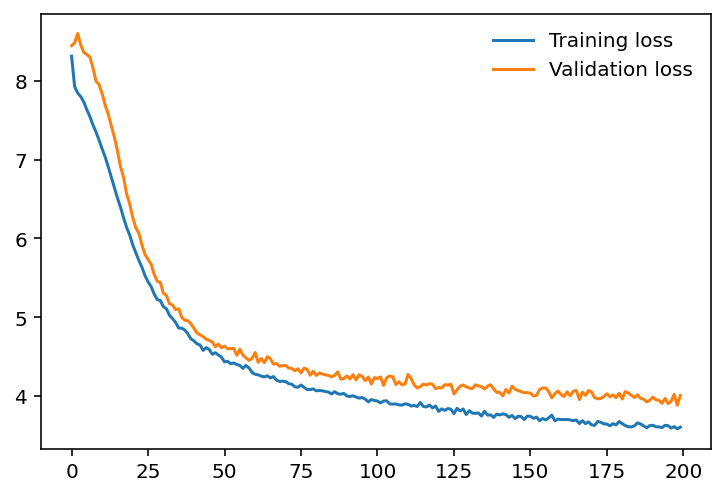

In [9]:
train_losses = np.load('./results/Training_1/Ftp1_train_loss_array.npy')
valid_losses = np.load('./results/Training_1/Ftp1_valid_loss_array.npy')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False) 

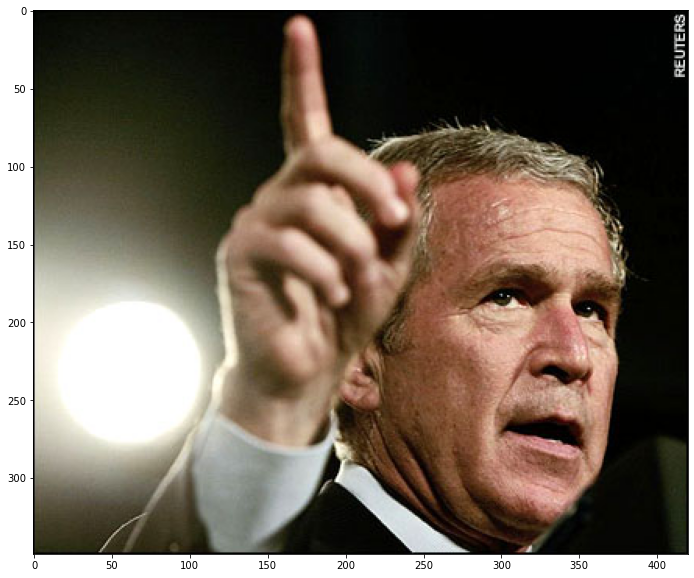

In [12]:
img_path = './data/face_test/big_bushi2.jpg'

# Read test picture
from PIL import Image, ImageDraw
%matplotlib inline
import matplotlib.pyplot as plt 

plt.figure(figsize=(48, 10)) # Set canvas size

img = Image.open(img_path)
plt.imshow(img)

In [13]:
import torch
model_path = './model/Training_1_Res_NLLLoss_2FC_200e.pt.pt'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load model
model=torch.load(model_path)
model.to(device);

In [14]:
from face_crop import face_crop
from torchvision import datasets,transforms 
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

img = Image.open(img_path)

valid_transform = transforms.Compose([
    face_crop(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,
                         std=std),
])



transformed_image = valid_transform(img).float()
with torch.no_grad():
    transformed_image = transformed_image
    transformed_image = transformed_image.unsqueeze(0)
    transformed_image = transformed_image.to(device)
    outputs = model(transformed_image)
#         plt.imshow(transformed_image)
#         print(transformed_image)
outputs = torch.exp(outputs)

In [15]:
top_p, top_k = torch.topk(outputs, 10, dim=1, largest=True, sorted=True, out=None)

In [16]:
import numpy as np
class_names = np.load("class_names.npy")


In [17]:
print('The most similar person is {}.'.format(class_names[top_k[0][0].item()]))
print('Similarity is {:.2%}'.format(top_p[0][0].item()))
print('\n')
print('The second similar person is {}.'.format(class_names[top_k[0][1].item()]))
print('Similarity is {:.2%}'.format(top_p[0][1].item()))
print('\n')
print('The third similar person is {}.'.format(class_names[top_k[0][2].item()]))
print('Similarity is {:.2%}'.format(top_p[0][2].item()))

The most similar person is George_W_Bush.
Similarity is 19.71%


The second similar person is Geoff_Hoon.
Similarity is 7.29%


The third similar person is Gerard_Depardieu.
Similarity is 6.97%
